In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
class SentimentRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SentimentRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.unsqueeze(1)  # Agregar una dimensión para la secuencia
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [3]:
# Comprobar si CUDA está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

df = pd.read_csv('train.csv')

# Vectorizar los textos
vectorizer = CountVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2), lowercase=True)
vectorizer2 = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2), lowercase=True)
X = vectorizer2.fit_transform(df['message']).toarray()

# Convertir las etiquetas a valores numéricos
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = SentimentDataset(X_train, y_train)
test_dataset = SentimentDataset(X_test, y_test)

input_size = X_train.shape[1]
hidden_size = 128
output_size = len(np.unique(y))

model = SentimentRNN(input_size, hidden_size, output_size)
model.to(device)

# Entrenar el modelo
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30
losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

# Evaluar el modelo
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())


Using device: cuda
Epoch 1/30, Loss: 0.3885
Epoch 2/30, Loss: 0.2213
Epoch 3/30, Loss: 0.1881
Epoch 4/30, Loss: 0.1695
Epoch 5/30, Loss: 0.1573
Epoch 6/30, Loss: 0.1471
Epoch 7/30, Loss: 0.1394
Epoch 8/30, Loss: 0.1334
Epoch 9/30, Loss: 0.1261
Epoch 10/30, Loss: 0.1220
Epoch 11/30, Loss: 0.1159
Epoch 12/30, Loss: 0.1132
Epoch 13/30, Loss: 0.1082
Epoch 14/30, Loss: 0.1052
Epoch 15/30, Loss: 0.1014
Epoch 16/30, Loss: 0.0978
Epoch 17/30, Loss: 0.0954
Epoch 18/30, Loss: 0.0934
Epoch 19/30, Loss: 0.0889
Epoch 20/30, Loss: 0.0850
Epoch 21/30, Loss: 0.0836
Epoch 22/30, Loss: 0.0799
Epoch 23/30, Loss: 0.0772
Epoch 24/30, Loss: 0.0761
Epoch 25/30, Loss: 0.0718
Epoch 26/30, Loss: 0.0695
Epoch 27/30, Loss: 0.0691
Epoch 28/30, Loss: 0.0652
Epoch 29/30, Loss: 0.0627
Epoch 30/30, Loss: 0.0608


Accuracy: 0.8218
Classification Report:
              precision    recall  f1-score   support

         neg       0.81      0.82      0.82      2446
         pos       0.83      0.82      0.82      2554

    accuracy                           0.82      5000
   macro avg       0.82      0.82      0.82      5000
weighted avg       0.82      0.82      0.82      5000



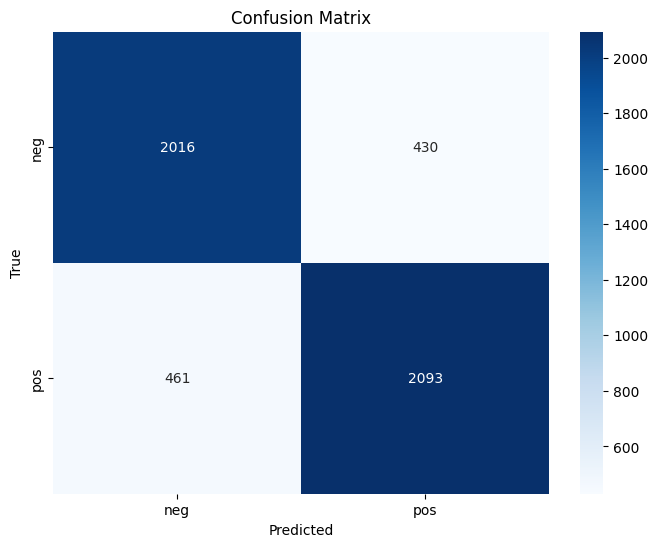

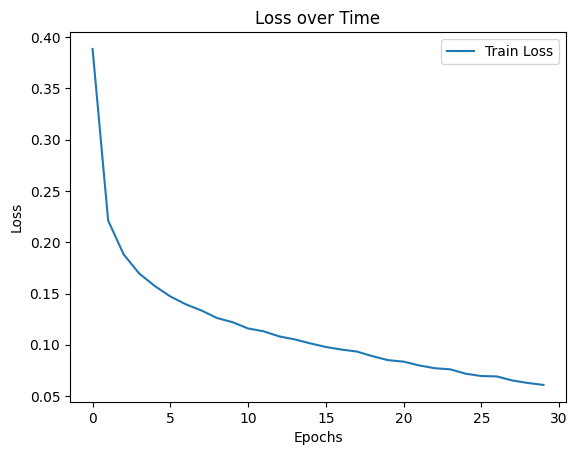

In [4]:
accuracy = accuracy_score(all_labels, all_predictions)
class_report = classification_report(all_labels, all_predictions, target_names=label_encoder.classes_)
cm = confusion_matrix(all_labels, all_predictions)

print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(class_report)

# Graficar la matriz de confusión con seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Graficar la pérdida a lo largo del tiempo
plt.plot(losses, label='Train Loss')
plt.title('Loss over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()